# RESOLVE and ECO HI Tutorial

This Jupyter tutorial provides an overview of the RESOLVE and ECO 21cm data, including new restructuring of our database variables that will become available in ECO DR3 and RESOLVE DR4. The REsolved Spectroscopy Of a Local VolumE (RESOLVE) survey contains a highly-complete atomic gas census published in Stark et al. (2016). The Environmental COntext (ECO) catalog surrounds the A-semester of RESOLVE in a 10x larger volume, composed primarily of reprocessed archival data including HI data from RESOLVE and ALFALFA. For more details on the surveys and the 21 cm data, please visit https://resolve.astro.unc.edu/.

Author: Zack Hutchens<br/>
Date: January 2021

## (1) Data Selection

**NOTE**: To complete this tutorial, you will need a private, team-only version of the ECO catalog. To obtain this dataset, please log onto https://resolve-g3.slack.com, or obtain a team-only catalog from https://resolve.astro.unc.edu.

There are many galaxies in the RESOLVE and ECO databases which are not part of the official survey, for example because they are fainter than the luminosity completeness floor, or because they have redshifts outside of the official volume. For this tutorial, we will use the original luminosity-complete and volume-limited selection. For details on this selection and other possible samples, see the RESOLVE Data Tutorial (https://github.com/resolvesurvey/database-tutorial). ECO has recently been updated with a fresh crossmatch from SDSS DR7/DR8 for improved redshifts, as well as harmonization of r-band magnitudes with RESOLVE. 

The new version of ECO also contains additional selection criteria based on new classifications of duplicate entries. Non-duplicates may be selected with the `dup` flag with criterion `dup<=0`. Database entries for which `dup>0` represent carbon-copy targets or, for example, entries that represent a second, off-center image of a galaxy. The value `dup=0` represents entries that haven't been manually inspected for duplicate status, and thus we have no motivation to exclude them from the official survey. Please see the full key for additional details (https://users.castle.unc.edu/~zhutchen/dupkey.txt).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
resolvepath="RESOLVE_DR4_prepubl.csv"
ecopath="ECO-teamonlyMarch2021.csv"
fullresolve = np.genfromtxt(resolvepath, delimiter=",", dtype=None, names=True, encoding='utf-8')
fulleco = np.genfromtxt(ecopath, delimiter=',', dtype=None, names=True, encoding='utf-8')

# use luminosity-limited samples (group redshift boundaries + luminosity limit)
resolve = fullresolve[np.where((fullresolve['grpcz']>4500.) & (fullresolve['grpcz']<7000.) & \
                               (fullresolve['fl_insample']))]
eco = fulleco[np.where((fulleco['grpcz']>3000.) & (fulleco['grpcz']<7000.) & (fulleco['absrmag']<=-17.33) & \
                      (fulleco['dup']<=0))]

## (2) Overview the RESOLVE and ECO HI Data
The RESOLVE survey contains a complete atomic gas census sourced from the ALFALFA survey and deep observations with Arecibo and the Green Bank Telescope (see Stark et al., 2016). The main HI-related data columns are: 

- `mhidet`: HI masses for 21cm detections assuming H0 = 70 (km/s)/Mpc
- `emhidet`: Statistical uncertainty on HI masses for 21cm detections
- `mhilim`: Upper limit HI masses for 21cm non-detections assuming H0 = 70 (km/s)/Mpc ($3\sigma$ limits for RESOLVE, see note below for ECO)
- `limflag`: 1/0 flag indicating upper limit status; 0 if detection or unobserved; `limflag = (mhilim>0)`
- `confused`: flag indicating confusion in the `mhidet` column
- `w50`: peak HI linewidth at 50% level in km/s
- `w20`: peak HI linewidth at 20% level in km/s
- `peaksnhi`: peak SNR of 21 cm line; ideally prefer SNR > 5-6 for a reliable linewidth
- `logmgas`: best estimate of gas content utilizing detections & strong upper limits, while estimating for weak limits and badly confused observations.

The RESOLVE and ECO wiki sites contain a full glossary of all variables. You may wish to contrast these with the naming conventions used in the public RESOLVE DR3. While the actual HI data has not changed for RESOLVE, the columns have been restructured, and older conventions are now deprecated (e.g., `mhi` is now deprecated to `mhidep`). 

On the other hand, ECO has recently seen a complete overhaul of its HI inventory, based on a new crossmatch with ALFALFA-100 ($\alpha$100, Haynes et al., 2018). This crossmatch has added **~5,000 detections or upper limits** to ECO beyond what was available from $\alpha$40 and RESOLVE-A. For ECO, naming conventions match RESOLVE, such as in the list above. However, for ECO, non-detections are compiled heterogeneously, so we compute upper limit masses as `mhilim = limmult*limsigma`, where:

- `limsigma`: 21 cm mass noise for non-detections, σ_M, based on estimated RMS noise and estimated W20 linewidth. 0 for detections. 
- `limmult`: Scalar multiplier, X, by which to scale an upper limit mass (mhilim) from `limsigma`. We use a value of X=3 within the RESOLVE-A region, where HI spectra were extracted with the optical position known as a prior. Outside RESOLVE-A, we use X=5 to characterize upper limit masses for what would have been a blind detection.

With that, we can compute the upper limit masses for the ECO survey:

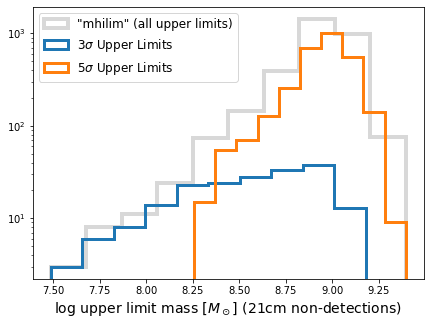

In [3]:
eco['mhilim'] = eco['limmult']*eco['limsigma']

plt.figure(figsize=(7,5))
selall = np.where(eco['limmult']>0)
plt.hist(np.log10(eco['mhilim'][selall]), histtype='step', color='grey', alpha=0.3, linewidth=4, label='"mhilim" (all upper limits)')
sel3 = np.where(eco['limmult']==3)
plt.hist(np.log10(eco['mhilim'][sel3]), histtype='step', label=r'$3\sigma$ Upper Limits', linewidth=3)
sel5 = np.where(eco['limmult']==5)
plt.hist(np.log10(eco['mhilim'][sel5]), histtype='step', label=r'$5\sigma$ Upper Limits', linewidth=3)
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.xlabel(r"log upper limit mass [$M_\odot$] (21cm non-detections)", fontsize=14)
plt.show()

You can see that ECO contains far more $5\sigma$ upper limits than $3\sigma$ limits. This is because the main data columns is sourced extensively from ALFALFA, which provides blind detections. ECO does inherit the high-quality HI data from RESOLVE-A, providing $3\sigma$ limits, but for a smaller subset of galaxies.

Note also that the default HI masses in RESOLVE and ECO have been computed using 
$$ M_{\rm HI} = \left(2.36\times10^5\right)\left(\frac{cz}{H_0}\right)^2 f_{\rm HI}, $$
in which $cz$ is the Local Group-corrected recessional velocity of the galaxy. This calculation is the most general-purpose distance estimation, but it is susceptible error because $cz$ reflects the peculiar motion of galaxies in addition to their cosmological redshift. To remove this effect based on group finding, scale the HI masses and their uncertainties as below:

In [4]:
resolve_sf = (resolve['grpcz']/resolve['cz'])**2.0
resolve['mhidet'] *= resolve_sf
resolve['emhidet'] *= resolve_sf
resolve['mhilim'] *= resolve_sf

eco_sf = (eco['grpcz']/eco['cz'])**2.0
eco['mhidet'] *= eco_sf
eco['emhidet'] *= eco_sf
eco['mhilim'] *= eco_sf

### Example: Sky Coverage of 21cm Data in ECO
To illustrate how the naming conventions of HI variables have changed, let's make two sky plots using the deprecated and new HI variables. In the left plot, we'll use deprecated variables to show our HI coverage of the ECO sky, and the right plot, we'll use the new variables to see how much HI data has been added.

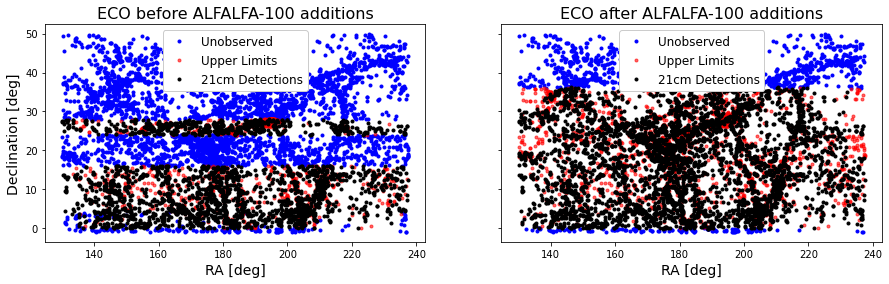

In [5]:
fig, (axl, axr) = plt.subplots(ncols=2,sharey=True,figsize=(15,4))

# left plot --- deprecated variable names (mhidep, etc.)
unobssel = np.where(np.logical_and(eco['mhidep']==0, np.logical_not(eco['limflagdep'])))
axl.plot(eco['radeg'][unobssel], eco['dedeg'][unobssel], 'b.', label="Unobserved")

limsel = np.where(eco['limflagdep'])
axl.plot(eco['radeg'][limsel], eco['dedeg'][limsel], 'r.', alpha=0.6, label="Upper Limits")

detsel = np.where(np.logical_and(eco['mhidep']>0, np.logical_not(eco['limflagdep']))) 
axl.plot(eco['radeg'][detsel], eco['dedeg'][detsel], 'k.', label="21cm Detections")


axl.legend(loc='best', framealpha=1, fontsize=12)
axl.set_xlabel("RA [deg]", fontsize=14)
axl.set_ylabel("Declination [deg]", fontsize=14)
axl.set_title("ECO before ALFALFA-100 additions", fontsize=16)

# right plot --- new variable names + a100 data
unobssel = np.where(np.logical_and(eco['mhidet']==0, eco['mhilim']==0))
axr.plot(eco['radeg'][unobssel], eco['dedeg'][unobssel], 'b.', label="Unobserved")

limsel = np.where(eco['mhilim']>0)
axr.plot(eco['radeg'][limsel], eco['dedeg'][limsel], 'r.', alpha=0.6, label="Upper Limits")

detsel = np.where((eco['mhidet']>0))
axr.plot(eco['radeg'][detsel], eco['dedeg'][detsel], 'k.', label="21cm Detections")

axr.legend(loc='best', framealpha=1, fontsize=12)
axr.set_xlabel("RA [deg]", fontsize=14)
axr.set_title("ECO after ALFALFA-100 additions", fontsize=16)
plt.show()

## (3) Categories of HI Data in ECO

ECO also includes additional categories of HI data that provide a different perspective on its 21cm inventory. The three categories of HI data in ECO are:

1. `mhidet_a100, mhilim_a100, ...`: HI data columns uniformly compiled from ALFALFA-100. No inheritance from RESOLVE.
2. `mhidet_e16, mhilim_e16, ...`: HI data columns preserving the HI inventory in Eckert+ (2016): RESOLVE-A and ALFALFA-40.
3. `mhidet, mhilim, ...`: The "main" columns which inherit RESOLVE-A and source from ALFALFA-100 elsewhere. 

Category #3 will be preferred for most analyses, as it includes RESOLVE's high-quality HI data and contains the most 21cm data overall. Do NOT haphazardly mix and match these three categories, as they are compiled differently and may not always line-up. For example, the `mhilim_e16` will often report upper limit masses for galaxies that have 21cm detections in `mhidet`, since the Eckert+2016 sample did not include ALFALFA-100.

### Example #1: HI Gas Fractions and Stellar Mass

In this next example, let's compare the three ECO HI samples with RESOLVE's HI census. To do so, let's make four-panel plot showing the simple relation between gas-to-stellar mass ratio and stellar mass.

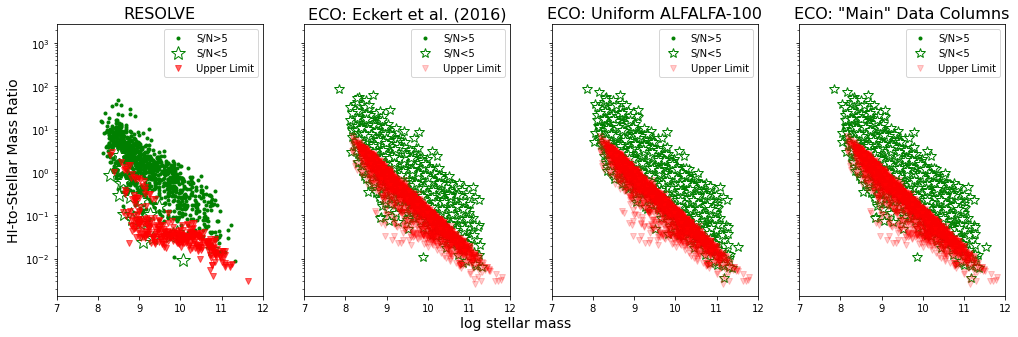

In [6]:
resolve_hisnr=np.zeros(len(resolve))
sel = np.where(resolve['emhidet']>0)
resolve_hisnr[sel] = resolve['mhidet'][sel]/resolve['emhidet'][sel]

fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(17,5))
fig.text(0.5, 0.04, 'log stellar mass', fontsize=14, ha='center')

# in ax0 (left-most), let's plot for RESOLVE. We can split into three categories: high SNR, lower SNR, upper limit.
highsnr = (resolve_hisnr>5) & (resolve['mhidet']>0)
ax[0].plot(resolve['logmstar'][highsnr], resolve['mhidet'][highsnr]/10**resolve['logmstar'][highsnr], 'g.', label='S/N>5')

lowsnr = (resolve_hisnr<5) & (resolve['mhidet']>0)
ax[0].plot(resolve['logmstar'][lowsnr], resolve['mhidet'][lowsnr]/10**resolve['logmstar'][lowsnr], 'g*', label='S/N<5', markersize=15, markerfacecolor="white")

uplim = (resolve['mhilim']>0)
ax[0].plot(resolve['logmstar'][uplim], resolve['mhilim'][uplim]/10**resolve['logmstar'][uplim], 'rv', label='Upper Limit', alpha=0.6)

ax[0].set_title("RESOLVE", fontsize=16)
ax[0].set_ylabel("HI-to-Stellar Mass Ratio", fontsize=14)
ax[0].set_yscale('log')
ax[0].legend(loc='best')
ax[0].set_xlim(7,12)

# in ax1-ax3, let's plot ECO for the three HI samples.
catsuffixlist = ['_e16', '_a100', '']
titles=['ECO: Eckert et al. (2016)', 'ECO: Uniform ALFALFA-100', 'ECO: "Main" Data Columns']
for i in range(1,4):
    suffix = catsuffixlist[i-1]
    
    # compute S/N using uncertainty on MHI
    ecopeaksnhi = np.zeros(len(eco))
    detsel = np.where(eco['mhidet'+suffix]>0)
    ecopeaksnhi[detsel] = eco['mhidet'+suffix][detsel]/eco['emhidet'+suffix][detsel]
    
    highsnr = (eco['mhidet'+suffix]>0) & (ecopeaksnhi>5) & (eco['logmstar']>0)
    ax[i].plot(eco['logmstar'][highsnr], eco['mhidet'][highsnr]/10**eco['logmstar'][highsnr], 'g.', label='S/N>5')
    
    lowsnr = (eco['mhidet'+suffix]>0) & (ecopeaksnhi>5) & (eco['logmstar']>0)
    ax[i].plot(eco['logmstar'][lowsnr], eco['mhidet'][lowsnr]/10**eco['logmstar'][lowsnr], 'g*', label='S/N<5', markersize=10, markerfacecolor="white")

    uplim = (eco['mhilim']>0) & (eco['logmstar']>0)
    ax[i].plot(eco['logmstar'][uplim], eco['mhilim'][uplim]/10**eco['logmstar'][uplim], 'rv', label='Upper Limit', alpha=0.2)

    ax[i].set_title(titles[i-1], fontsize=16)
    ax[i].legend(loc='best')
    ax[i].set_xlim(7,12)

plt.show()

### Example 2: Tully-Fisher Relation

As another example, we can try to explore the Tully-Fisher relation for 21cm detections galaxies in the ECO sample. For a reliable W50 linewidth, we should aim for a SNR of 5-6 in the 21cm line, which can be assessed using the `peaksnhi` parameter.

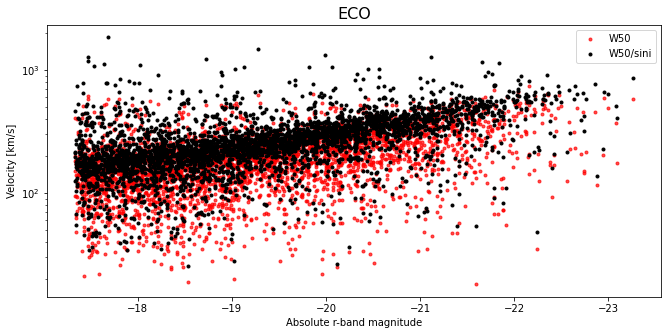

In [7]:
fig, (ax1) = plt.subplots(figsize=(11,5))

# eco
sel = (eco['mhidet']>0) & (eco['peaksnhi']>6)
ax1.plot(eco['absrmag'][sel], eco['w50'][sel], 'r.', alpha=0.7, label='W50')
ax1.plot(eco['absrmag'][sel], eco['w50'][sel]/np.sin(np.arccos(eco['b_a'][sel])), 'k.', alpha=1, label=r'W50/sini')
ax1.invert_xaxis()
ax1.set_title("ECO",fontsize=16)
ax1.set_xlabel("Absolute r-band magnitude")
ax1.set_ylabel("Velocity [km/s]")
ax1.legend(loc='best')

plt.yscale('log')
plt.show()